# 🧠 Modeling

## Step 1: Compute covariance matrix

In [17]:
import seaborn as sns
from sklearn.decomposition import PCA
from tabulate import tabulate
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from statsmodels.tsa.stattools import acf, pacf, adfuller
from statsmodels.tsa.arima.model import ARIMA

In [18]:
df_scaled = df_train_scaled

In [19]:
# Compute covariance matrix using pandas
C = df_scaled[target].cov()

# Print the covariance matrix
print("\nCovariance Matrix (pandas):\n", C)



Covariance Matrix (pandas):
               meantemp  humidity  wind_speed  meanpressure
meantemp      1.000856 -0.593778    0.304062     -0.890564
humidity     -0.593778  1.000856   -0.362807      0.378659
wind_speed    0.304062 -0.362807    1.000856     -0.298500
meanpressure -0.890564  0.378659   -0.298500      1.000856


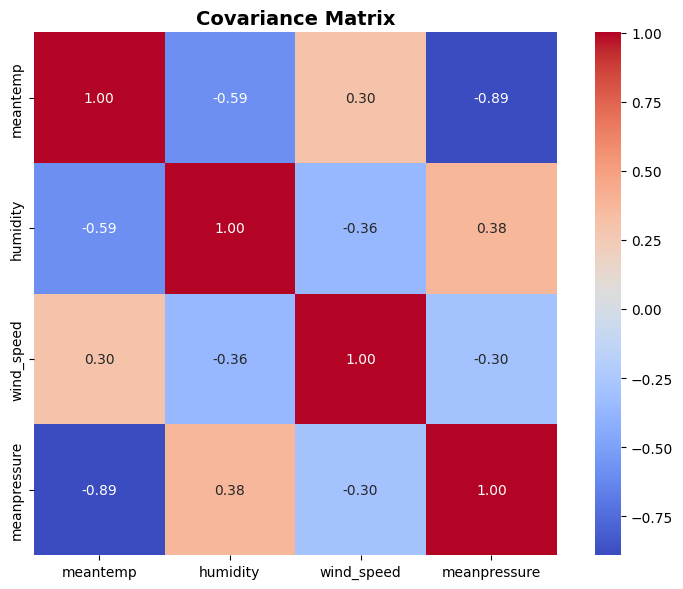

In [20]:
# Covariance matrix
C = df_scaled[target].cov()

plt.figure(figsize=(8,6))
sns.heatmap(C, annot=True, fmt=".2f", cmap="coolwarm", cbar=True, square=True)

plt.title("Covariance Matrix", fontsize=14, fontweight="bold")
plt.tight_layout()
plt.show()

## Step 2: PCA - Find Latent Variables

In [21]:
# PCA
pca = PCA()
pca.fit(X_train_scaled)

,n_components,None
,copy,True
,whiten,False
,svd_solver,'auto'
,tol,0.0
,iterated_power,'auto'
,n_oversamples,10
,power_iteration_normalizer,'auto'
,random_state,None


In [22]:
# Analyze results
explained_variance = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)

In [23]:
print("📊 VARIANCE ANALYSIS:")

# Create a nicely formatted results table
pca_results = []
for i, (var, cum_var) in enumerate(zip(explained_variance, cumulative_variance)):
    pca_results.append({
        'Principal Component': f'PC{i+1}',
        'Eigenvalue': pca.explained_variance_[i],
        'Variance Ratio': var,
        'Cumulative Variance': cum_var
    })

pca_df = pd.DataFrame(pca_results)
print(pca_df.round(4))

📊 VARIANCE ANALYSIS:
  Principal Component  Eigenvalue  Variance Ratio  Cumulative Variance
0                 PC1      2.4726          0.6176               0.6176
1                 PC2      0.8510          0.2126               0.8302
2                 PC3      0.6065          0.1515               0.9817
3                 PC4      0.0733          0.0183               1.0000


Principal Component: Component name (PC1, PC2, PC3, PC4)

Eigenvalue: Importance of the component (the larger the number, the more important it is)

Variance Ratio: Percentage of information that the component holds

Cumulative Variance: Total percentage of information from the first component up to the current component

In [24]:
# Select the number of principal components (p)
# Usually choose the number of PCs that explain 80-95% of the variance
p = np.argmax(cumulative_variance >= 0.80) + 1
print(f"\n🎯 SELECT {p} PRINCIPAL COMPONENTS")
print(f"📈 Explains {cumulative_variance[p-1]:.1%} of the variance")


🎯 SELECT 2 PRINCIPAL COMPONENTS
📈 Explains 83.0% of the variance


In [25]:
# Create the P_truncated matrix (keep only the first p components)
P_truncated = pca.components_[:p].T
print(f"\n📐 P_truncated matrix shape: {P_truncated.shape}")


📐 P_truncated matrix shape: (4, 2)


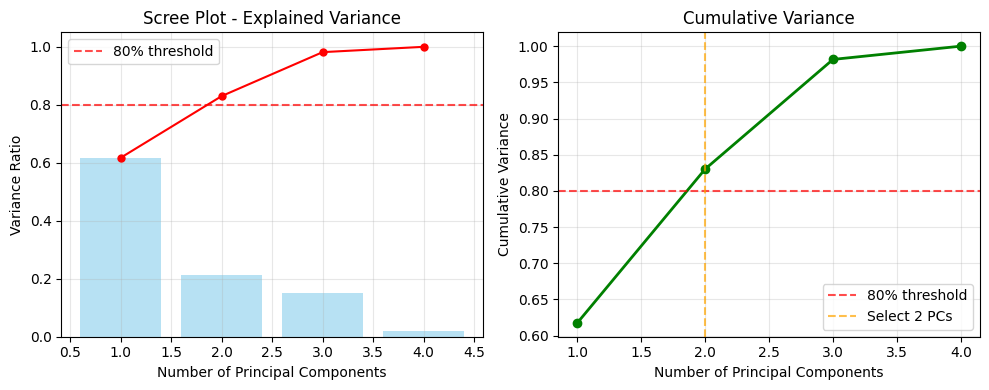

In [26]:
# Plot Scree Plot
plt.figure(figsize=(10, 4))

# Variance plot
plt.subplot(1, 2, 1)
plt.bar(range(1, len(explained_variance)+1), explained_variance, alpha=0.6, color='skyblue')
plt.plot(range(1, len(cumulative_variance)+1), cumulative_variance, 'ro-', markersize=5)
plt.axhline(y=0.80, color='r', linestyle='--', alpha=0.7, label='80% threshold')
plt.xlabel('Number of Principal Components')
plt.ylabel('Variance Ratio')
plt.title('Scree Plot - Explained Variance')
plt.legend()
plt.grid(True, alpha=0.3)

# Cumulative variance plot
plt.subplot(1, 2, 2)
plt.plot(range(1, len(cumulative_variance)+1), cumulative_variance, 'go-', linewidth=2)
plt.axhline(y=0.80, color='r', linestyle='--', alpha=0.7, label='80% threshold')
plt.axvline(x=p, color='orange', linestyle='--', alpha=0.7, label=f'Select {p} PCs')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Variance')
plt.title('Cumulative Variance')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


1. Scree Plot (Left Plot)
X-axis: Principal component number (1st, 2nd, 3rd, ...)

Y-axis: The proportion of variance explained by each individual component (how much information each component captures from the original data).

Bars: Each bar shows how much variance (information) is explained by that component alone. The first bar is usually the highest, meaning the first component captures the most information.

Red horizontal line: This is a threshold (for example, 80%) that you want to reach for explained variance.

Red dots: These mark the cumulative variance as you add more components. They help you see how many components you need to reach the threshold.

2. Cumulative Variance Plot (Right Plot)
X-axis: Principal component number (same as the left plot).

Y-axis: Cumulative proportion of variance explained (total information captured as you add more components).

Blue curve: Shows how the total explained variance increases as you include more components. It starts low and rises quickly, then levels off.

Red horizontal line: The same threshold (e.g., 80%) for total explained variance.

Yellow vertical line: Indicates the number of components needed to reach or exceed the threshold. For example, if the yellow line is at 3, it means the first 3 components together explain at least 80% of the variance.

## Step 3: Transform to Latent Space (Projection)

In [27]:
# Create PCA with the selected number of components
pca_final = PCA(n_components=p)
Z_train = pca_final.fit_transform(X_train_scaled)

In [29]:
# Create DataFrame for latent variables
latent_train = pd.DataFrame(Z_train, 
                        columns=[f'PC{i+1}' for i in range(p)],
                        index=data_train["date"])

print("✅ TRANSFORMED INTO LATENT SPACE")
print(f"📐 From {X_train_scaled.shape[1]} original dimensions → {p} latent dimensions")
print(f"📊 Retained {pca_final.explained_variance_ratio_.sum():.1%} of the information")

✅ TRANSFORMED INTO LATENT SPACE
📐 From 4 original dimensions → 2 latent dimensions
📊 Retained 83.0% of the information


In [30]:
# Display the first 5 rows of latent variables
print("\n📋 FIRST 5 ROWS OF LATENT VARIABLES:")
print(latent_train.head().round(4))


📋 FIRST 5 ROWS OF LATENT VARIABLES:
               PC1     PC2
date                      
2013-01-01 -2.8044 -0.5324
2013-01-02 -3.1558  0.1043
2013-01-03 -2.9713  0.5272
2013-01-04 -2.5540  0.0182
2013-01-05 -2.9735  0.3019


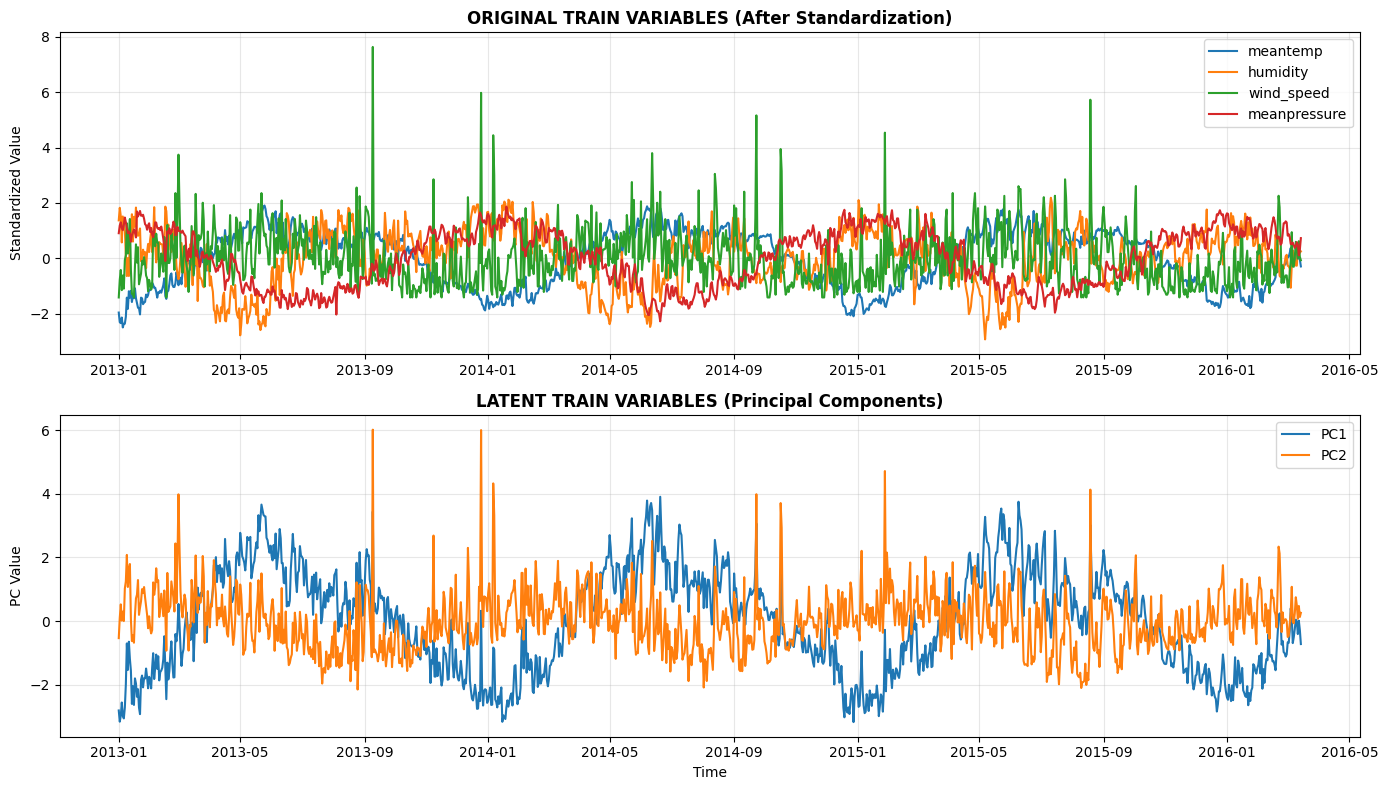

In [31]:
# Plot comparison: original variables vs latent variables
fig, axes = plt.subplots(2, 1, figsize=(14, 8))

# Original variables
for i, col in enumerate(target):
    axes[0].plot(data_train["date"], X_train_scaled[:, i], label=col, linewidth=1.5)
axes[0].set_title('ORIGINAL TRAIN VARIABLES (After Standardization)', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Standardized Value')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Latent variables
for i in range(p):
    axes[1].plot(data_train["date"], Z_train[:, i], label=f'PC{i+1}', linewidth=1.5)
axes[1].set_title('LATENT TRAIN VARIABLES (Principal Components)', fontsize=12, fontweight='bold')
axes[1].set_ylabel('PC Value')
axes[1].set_xlabel('Time')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


In [32]:
# Transform test data using the same PCA
Z_test = pca_final.transform(X_test_scaled)                  # Transform test data
latent_test = pd.DataFrame(Z_test,                           # Create test latent DataFrame
                         columns=[f'PC{i+1}' for i in range(p)],
                         index=data_test["date"])

# Combine for visualization if needed
latent_df = pd.concat([latent_train, latent_test])           # Combine for plots

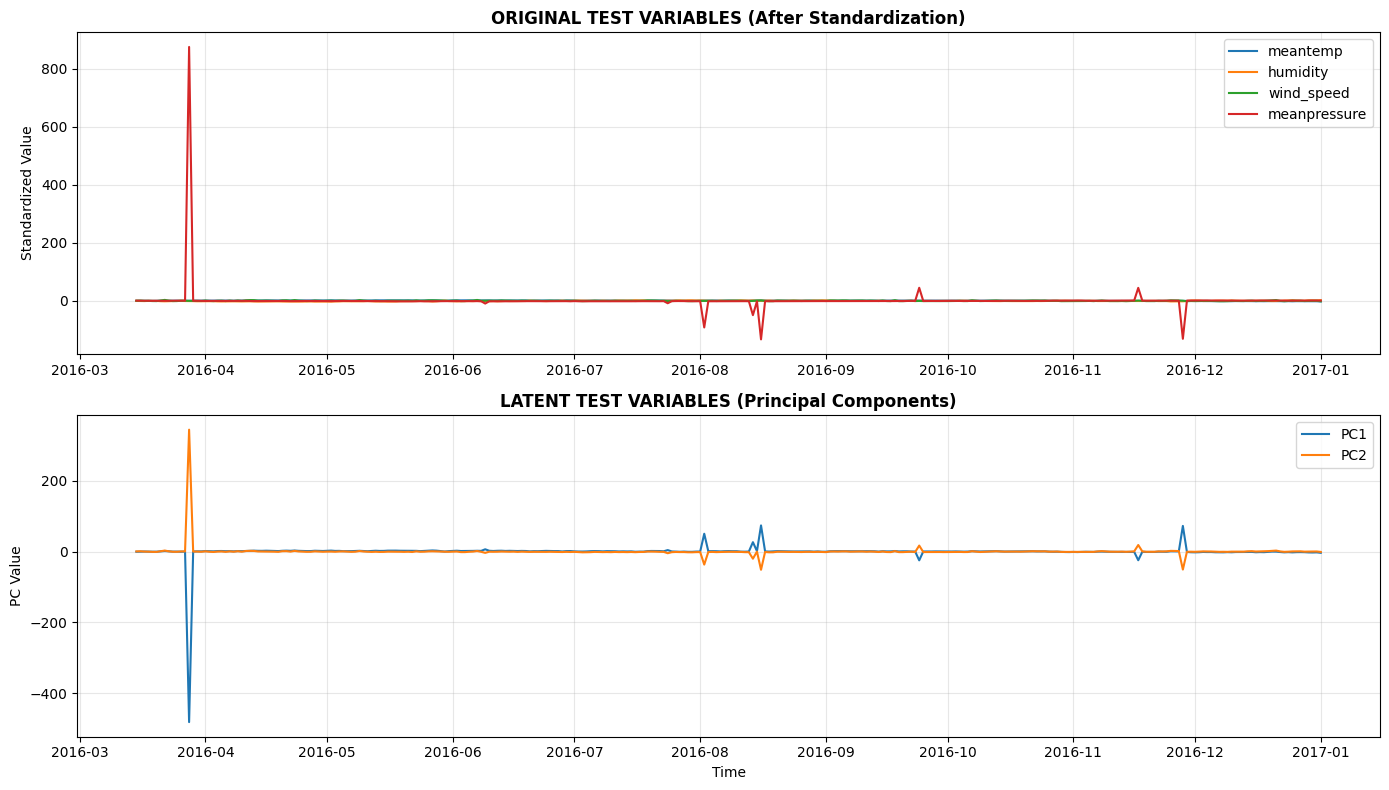

In [33]:
# Plot comparison: original variables vs latent variables for TEST data
fig, axes = plt.subplots(2, 1, figsize=(14, 8))

# Original test variables
for i, col in enumerate(target):
    axes[0].plot(data_test["date"], X_test_scaled[:, i], label=col, linewidth=1.5)
axes[0].set_title('ORIGINAL TEST VARIABLES (After Standardization)', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Standardized Value')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Latent test variables
for i in range(p):
    axes[1].plot(data_test["date"], Z_test[:, i], label=f'PC{i+1}', linewidth=1.5)
axes[1].set_title('LATENT TEST VARIABLES (Principal Components)', fontsize=12, fontweight='bold')
axes[1].set_ylabel('PC Value')
axes[1].set_xlabel('Time')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Step 4: Forecast on Latent Variables

In [34]:
print(f"📊 USING SPLIT DATA: Train {len(latent_train)} samples, Test {len(latent_test)} samples")

📊 USING SPLIT DATA: Train 1169 samples, Test 293 samples



🔮 STARTING FORECAST FOR EACH LATENT VARIABLE...
📈 Forecasting PC1...


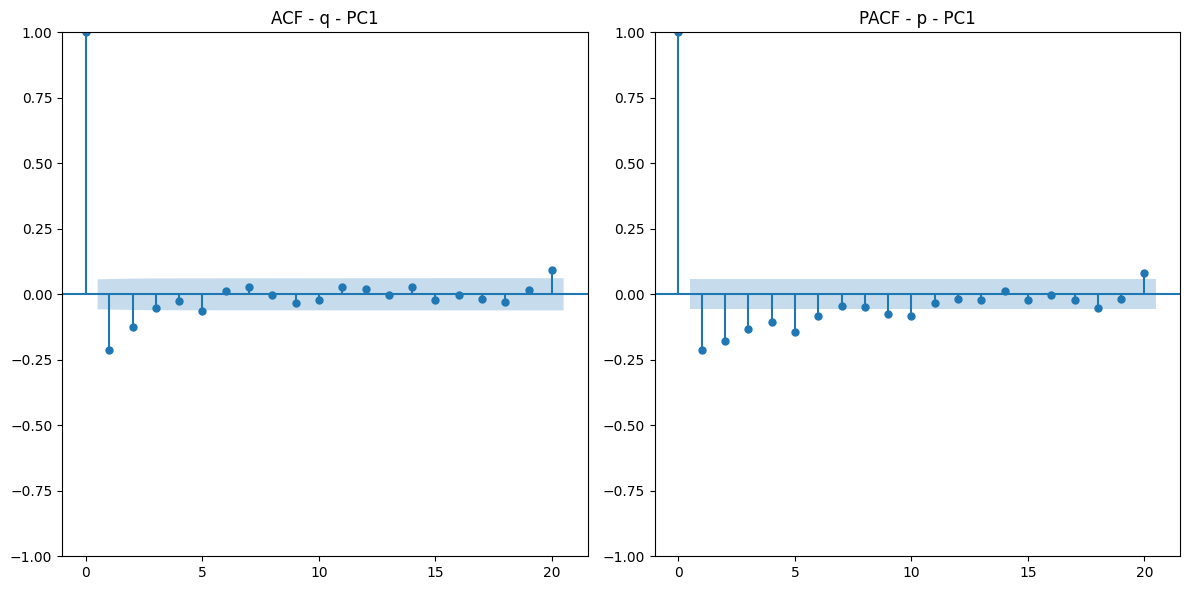

   🎯 Finding optimal model for PC1...
   ✅ Selected model: (2, 0, 1)
   📊 PC1: Successfully forecasted 293 steps
      Forecast values: [-0.55931165 -0.4775483  -0.43502351 -0.41232253 -0.3996406  -0.39202613
 -0.38697844 -0.38323462 -0.38015681 -0.37742286 -0.37487002 -0.37241605
 -0.37001937 -0.36765894 -0.36532409 -0.36300937 -0.36071201 -0.35843054
 -0.35616419 -0.35391251 -0.35167524 -0.3494522  -0.34724326 -0.3450483
 -0.34286723 -0.34069996 -0.33854638 -0.33640642 -0.33427999 -0.33216699
 -0.33006736 -0.32798099 -0.32590782 -0.32384775 -0.3218007  -0.31976659
 -0.31774534 -0.31573686 -0.31374108 -0.31175792 -0.30978729 -0.30782912
 -0.30588332 -0.30394983 -0.30202855 -0.30011942 -0.29822236 -0.29633729
 -0.29446414 -0.29260282 -0.29075327 -0.28891541 -0.28708917 -0.28527448
 -0.28347125 -0.28167942 -0.27989892 -0.27812967 -0.27637161 -0.27462466
 -0.27288875 -0.27116381 -0.26944978 -0.26774658 -0.26605415 -0.26437241
 -0.26270131 -0.26104077 -0.25939072 -0.25775111 -0.25612186 -

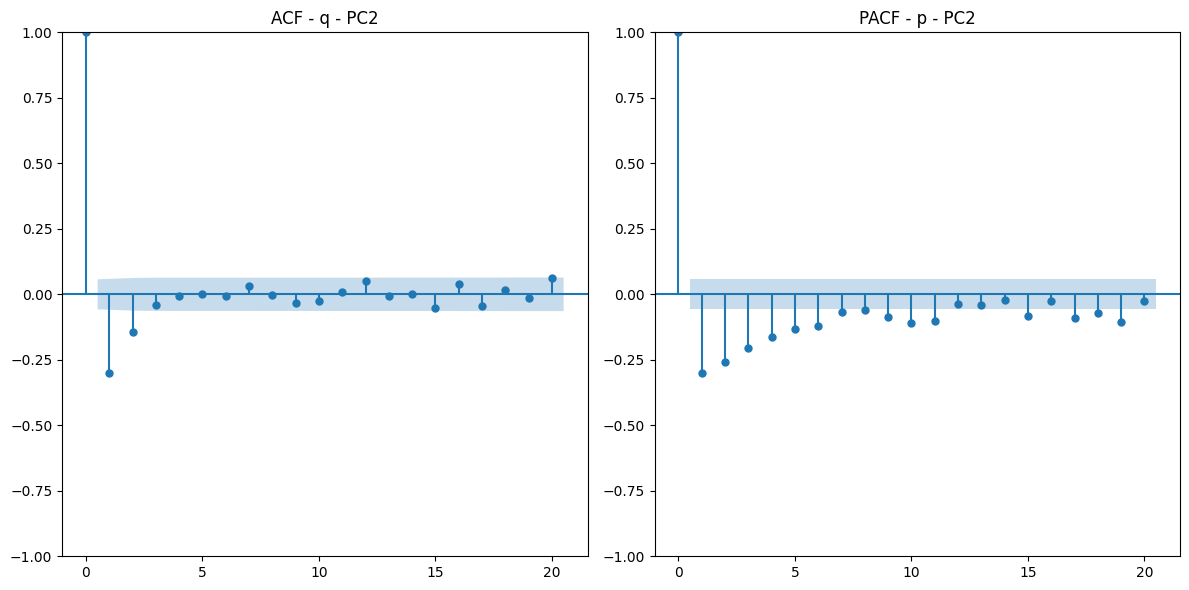

   🎯 Finding optimal model for PC2...
   ✅ Selected model: (2, 0, 1)
   📊 PC2: Successfully forecasted 293 steps
      Forecast values: [0.25033295 0.24492438 0.2412171  0.23814128 0.23531225 0.23259152
 0.2299291  0.22730681 0.22471789 0.22215971 0.2196311  0.21713143
 0.21466027 0.21221725 0.20980204 0.20741433 0.20505379 0.20272011
 0.20041299 0.19813213 0.19587723 0.19364799 0.19144412 0.18926534
 0.18711135 0.18498187 0.18287663 0.18079535 0.17873775 0.17670357
 0.17469254 0.1727044  0.17073889 0.16879574 0.16687471 0.16497555
 0.16309799 0.16124181 0.15940675 0.15759257 0.15579904 0.15402592
 0.15227299 0.15054    0.14882673 0.14713297 0.14545847 0.14380304
 0.14216645 0.14054848 0.13894893 0.13736758 0.13580422 0.13425866
 0.13273069 0.13122011 0.12972672 0.12825033 0.12679074 0.12534776
 0.1239212  0.12251088 0.1211166  0.1197382  0.11837548 0.11702828
 0.1156964  0.11437968 0.11307795 0.11179103 0.11051876 0.10926097
 0.10801749 0.10678817 0.10557283 0.10437133 0.1031835  0.10

In [35]:
# Forecast each latent variable
forecast_steps = len(latent_test)
latent_forecasts = []

print("\n🔮 STARTING FORECAST FOR EACH LATENT VARIABLE...")

for i, col in enumerate(latent_train.columns):
    print(f"📈 Forecasting {col}...")
    
    series = latent_train[col]
    
    # Plot ACF/PACF for analysis (optional)
    if len(series) > 30:  # Only plot if enough data
        y_train_diff = series.diff().dropna()
        
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
        plot_acf(y_train_diff, lags=20, alpha=0.05, ax=ax1, title=f'ACF - q - {col}')
        plot_pacf(y_train_diff, lags=20, alpha=0.05, ax=ax2, title=f'PACF - p - {col}')
        plt.tight_layout()
        plt.show()
    
        # Use auto_arima to find the optimal order
        print(f"   🎯 Finding optimal model for {col}...")
        model = pm.auto_arima(
            series, 
            start_p=0, start_q=0,
            max_p=5, max_q=5, 
            d=0,  # Already standardized, so d=0
            seasonal=False,   # Disable seasonality for latent variables
            stepwise=False,   # Speed optimization
            trace=False,      # Disable detailed logs for clarity
            error_action='ignore',
            suppress_warnings=True
        )
        
        print(f"   ✅ Selected model: {model.order}")
        
        # FORECAST: Use predict() instead of forecast()
        forecast = model.predict(n_periods=forecast_steps)
        latent_forecasts.append(forecast)
        
        print(f"   📊 {col}: Successfully forecasted {forecast_steps} steps")
        print(f"      Forecast values: {forecast.values}")
    

# Convert forecast results
latent_forecasts = np.array(latent_forecasts).T
print(f"\n✅ Completed forecasting {len(latent_forecasts)} latent variables")


In [36]:
print(f"Latent_forecasts shape = {np.array(latent_forecasts).shape}")
print(f"Latent_test index length = {len(latent_test.index)}")
print(f"Latent_train columns = {len(latent_train.columns)}")

Latent_forecasts shape = (293, 2)
Latent_test index length = 293
Latent_train columns = 2


In [37]:
forecast_array = np.array(latent_forecasts)
print(f"Forecast_array shape = {forecast_array.shape}")

Forecast_array shape = (293, 2)


In [38]:
# Create Forecast DataFrame
# Check and adjust shape if necessary
if forecast_array.shape[0] == len(latent_test.index):  # If already correct shape
    forecast_df = pd.DataFrame(
        forecast_array,
        columns=latent_train.columns,
        index=latent_test.index
    )
else:  # If needs transposing
    forecast_df = pd.DataFrame(
        forecast_array.T,
        columns=latent_train.columns,
        index=latent_test.index
    )

print("\n✅ COMPLETED FORECASTING ALL LATENT VARIABLES")
print(f"📊 Forecast_df shape: {forecast_df.shape}")



✅ COMPLETED FORECASTING ALL LATENT VARIABLES
📊 Forecast_df shape: (293, 2)


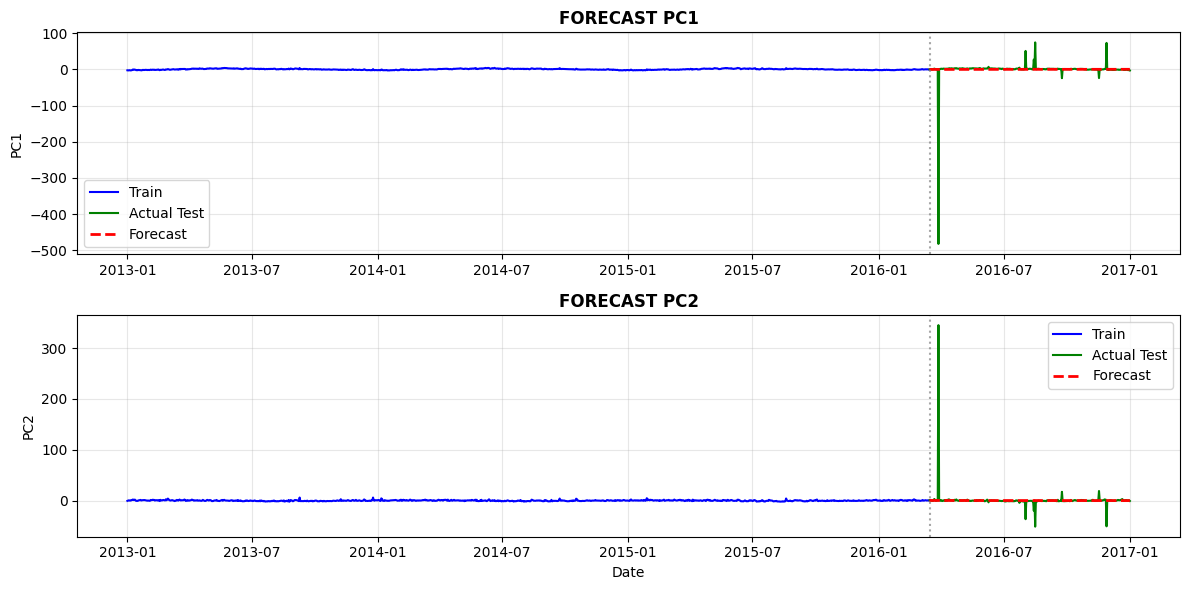

In [39]:
# Plot latent variable forecast results

plt.figure(figsize=(12, 3*p))

for i, col in enumerate(latent_train.columns, 1):
    plt.subplot(p, 1, i)
    
    # Actual data
    plt.plot(latent_train.index, latent_train[col], 'b-', label='Train', linewidth=1.5)
    plt.plot(latent_test.index, latent_test[col], 'g-', label='Actual Test', linewidth=1.5)
    
    # Forecast
    plt.plot(forecast_df.index, forecast_df[col], 'r--', label='Forecast', linewidth=2)
    
    # Train/Test split line
    split_date = latent_test.index[0]
    plt.axvline(x=split_date, color='gray', linestyle=':', alpha=0.7)
    
    plt.title(f'FORECAST {col}', fontsize=12, fontweight='bold')
    plt.ylabel(col)
    plt.legend()
    plt.grid(True, alpha=0.3)

plt.xlabel('Date')
plt.tight_layout()
plt.show()


## Step 5: Inverse Transformation back to Original Space

In [40]:
# Inverse transform from latent space back to standardized space
X_forecast_scaled = pca_final.inverse_transform(forecast_df)
print(f"   ✅ X_forecast_scaled shape: {X_forecast_scaled.shape}")

   ✅ X_forecast_scaled shape: (293, 4)


In [41]:
# Inverse transform from standardized values back to original scale
X_forecast_original = scaler.inverse_transform(X_forecast_scaled)
print(f"   ✅ X_forecast_original shape: {X_forecast_original.shape}")

   ✅ X_forecast_original shape: (293, 4)


In [42]:
# Create the final forecast DataFrame
final_forecast_df = pd.DataFrame(
    X_forecast_original,
    columns=target,
    index=forecast_df.index
)
print(f"   ✅ final_forecast_df shape: {final_forecast_df.shape}")
print(final_forecast_df.head().round(2))

   ✅ final_forecast_df shape: (293, 4)
            meantemp  humidity  wind_speed  meanpressure
date                                                    
2016-03-15     21.50     65.16        6.65       1011.86
2016-03-16     21.88     64.55        6.77       1011.50
2016-03-17     22.07     64.24        6.82       1011.31
2016-03-18     22.18     64.08        6.85       1011.20
2016-03-19     22.24     63.99        6.86       1011.14


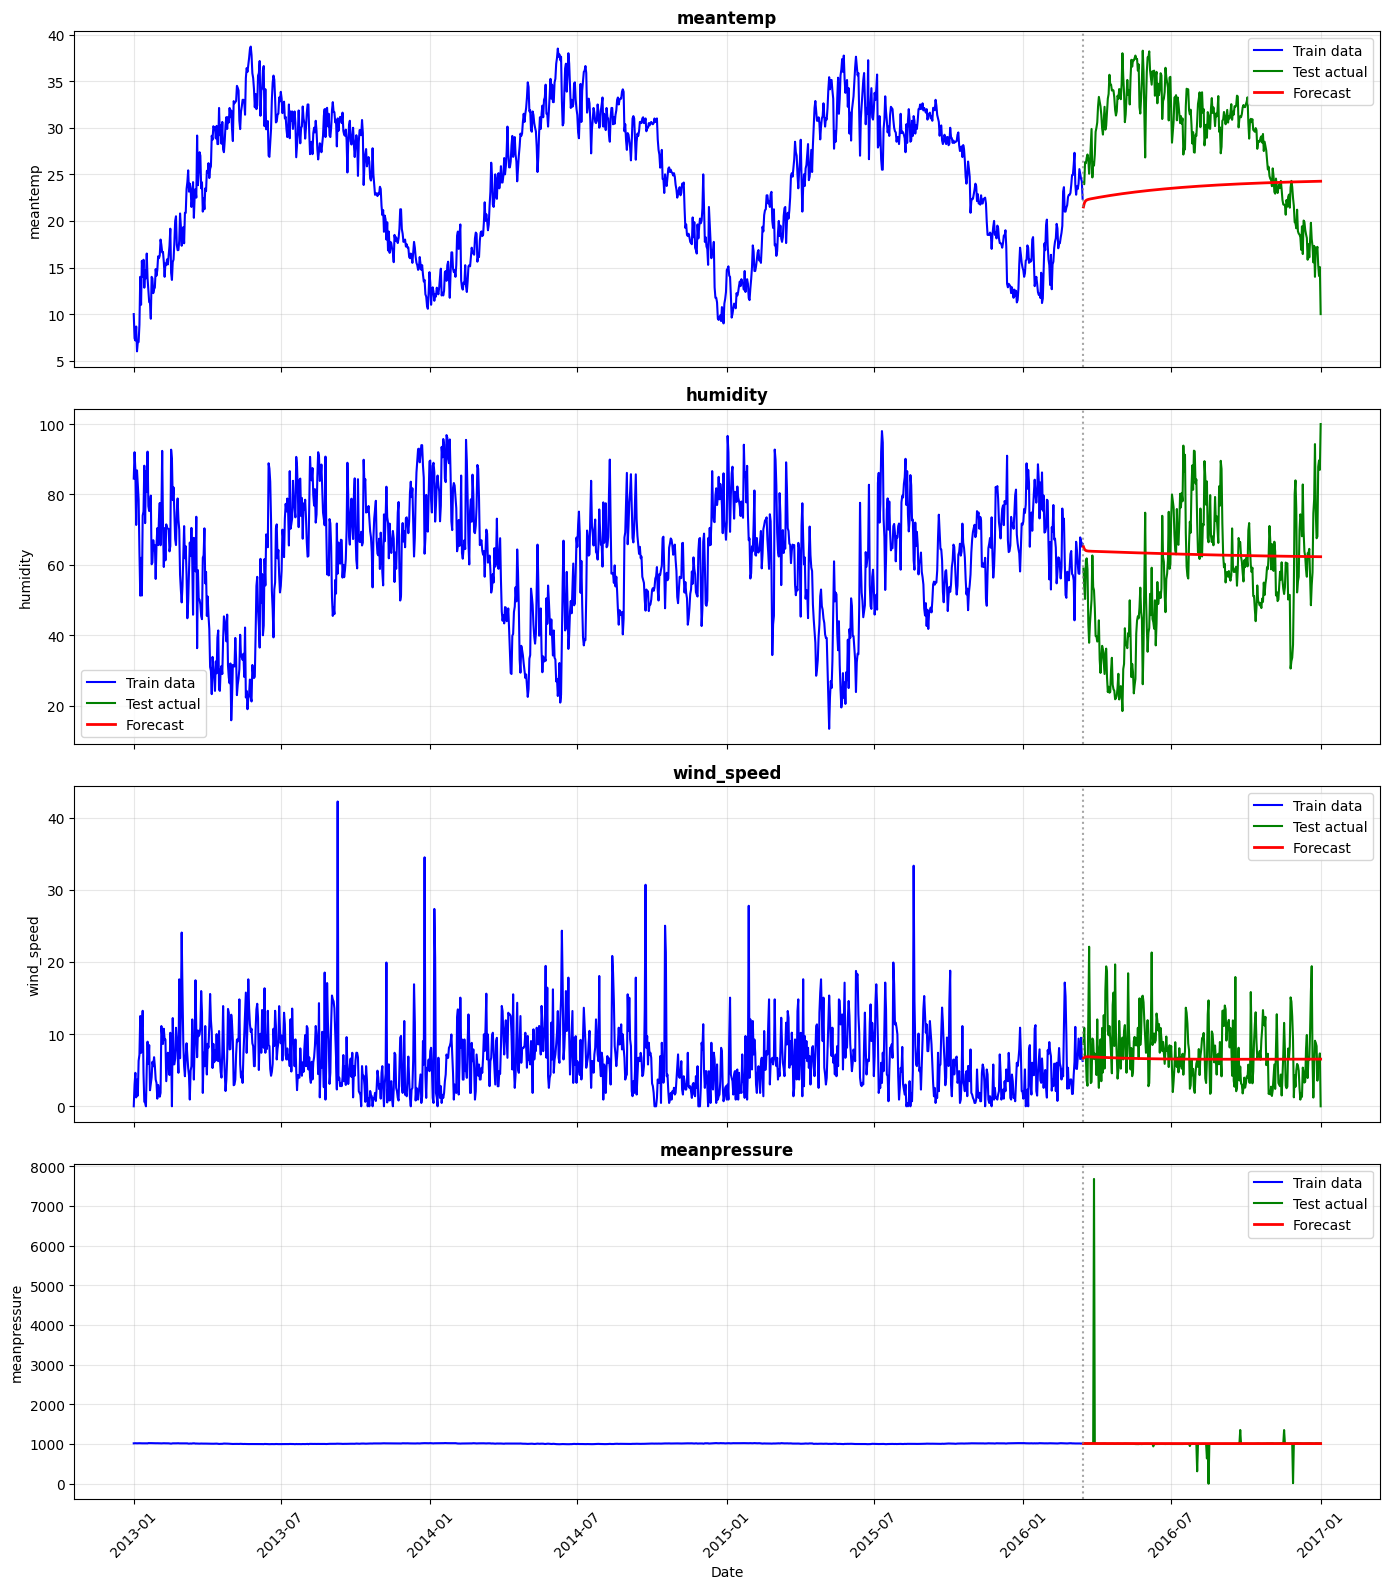

In [44]:
# Plotting
n_vars = len(target)

fig, axes = plt.subplots(nrows=n_vars, ncols=1, figsize=(14, 4*n_vars), sharex=True)

train_size = len(data_train)

# Plot each variable separately
for i, col in enumerate(target):
    # Train data
    axes[i].plot(df['date'][:train_size], 
                 df[col][:train_size], 
                 'blue', label='Train data', linewidth=1.5)
    
    # Test data (actual)
    axes[i].plot(df['date'][train_size:], 
                 df[col][train_size:], 
                 'green', label='Test actual', linewidth=1.5)
    
    # Forecast data
    axes[i].plot(final_forecast_df.index, 
                 final_forecast_df[col], 
                 'red', linestyle='-', label='Forecast', linewidth=2)
    
    # Vertical line to separate train/test
    axes[i].axvline(x=df['date'][train_size], color='gray', linestyle=':', alpha=0.7)
    
    axes[i].set_title(f"{col}", fontsize=12, fontweight="bold")
    axes[i].set_ylabel(col)
    axes[i].grid(True, alpha=0.3)
    axes[i].legend()

# X-axis label only at the bottom
axes[-1].set_xlabel("Date")
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

In [46]:
# Create DataFrame with 9 columns as required
result_df = pd.DataFrame({'date': df['date'][train_size:train_size + len(final_forecast_df)]})

# Define test_forecast_period first
test_forecast_period = df[target].iloc[train_size:train_size + len(final_forecast_df)]

for col in target:
    result_df[f'{col}_actual'] = test_forecast_period[col].values
    result_df[f'{col}_pred'] = final_forecast_df[col].values

print("Result DataFrame (9 columns):")

# Improve table display
pd.set_option('display.width', 1000)
pd.set_option('display.max_columns', 10)
pd.set_option('display.max_rows', 10)
pd.set_option('display.colheader_justify', 'center')

print(result_df.round(2))
print(f"\nShape: {result_df.shape}")
print(f"Columns: {list(result_df.columns)}")

Result DataFrame (9 columns):
        date     meantemp_actual  meantemp_pred  humidity_actual  humidity_pred  wind_speed_actual  wind_speed_pred  meanpressure_actual  meanpressure_pred
1169 2016-03-15       24.07           21.50           58.93           65.16             8.65             6.65              1014.87             1011.86     
1170 2016-03-16       23.94           21.88           53.75           64.55            10.88             6.77              1012.81             1011.50     
1171 2016-03-17       26.31           22.07           50.31           64.24             6.84             6.82              1010.44             1011.31     
1172 2016-03-18       26.19           22.18           61.25           64.08             6.71             6.85              1009.81             1011.20     
1173 2016-03-19       26.79           22.24           61.86           63.99             3.58             6.86              1009.21             1011.14     
...         ...              ...  